In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile, os

zip_path = '/content/drive/MyDrive/cleaned_dataset2 (2).zip'
extract_path = '/content/cleaned_dataset2'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted:", os.listdir(extract_path))


✅ Extracted: ['cleaned_dataset2']


In [ ]:
expected_folders = ['Train', 'Validate', 'Test']
contents = os.listdir(extract_path)
base_path = None

for folder in contents:
    candidate = os.path.join(extract_path, folder)
    if os.path.isdir(candidate):
        subfolders = os.listdir(candidate)
        if all(f in subfolders for f in expected_folders):
            base_path = candidate
            break

if base_path is None:
    raise Exception("❌ Could not locate Train/Validate/Test folders.")
print("✅ Base path set to:", base_path)


✅ Base path set to: /content/cleaned_dataset2/cleaned_dataset2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2131 images belonging to 8 classes.
Found 303 images belonging to 8 classes.
Found 616 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,566,408 (28.86 MB)

 Trainable params: 1,604,552 (6.12 MB)

 Non-trainable params: 5,961,856 (22.74 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_densenet121_model.h5',
                             monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.2492 - loss: 2.1653
Epoch 1: val_accuracy improved from -inf to 0.63036, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2508 - loss: 2.1613 - val_accuracy: 0.6304 - val_loss: 1.2103
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5177 - loss: 1.3859
Epoch 2: val_accuracy improved from 0.63036 to 0.70627, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step - accuracy: 0.5181 - loss: 1.3848 - val_accuracy: 0.7063 - val_loss: 0.9343
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6241 - loss: 1.0952
Epoch 3: val_accuracy improved from 0.70627 to 0.74917, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.6241 - loss: 1.0951 - val_accuracy: 0.7492 - val_loss: 0.7862
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6582 - loss: 0.9661
Epoch 4: val_accuracy improved from 0.74917 to 0.77888, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 451ms/step - accuracy: 0.6584 - loss: 0.9655 - val_accuracy: 0.7789 - val_loss: 0.6989
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7165 - loss: 0.8035
Epoch 5: val_accuracy improved from 0.77888 to 0.80528, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - accuracy: 0.7164 - loss: 0.8039 - val_accuracy: 0.8053 - val_loss: 0.6455
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7165 - loss: 0.8022
Epoch 6: val_accuracy improved from 0.80528 to 0.80858, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 446ms/step - accuracy: 0.7165 - loss: 0.8021 - val_accuracy: 0.8086 - val_loss: 0.6124
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7531 - loss: 0.6801
Epoch 7: val_accuracy did not improve from 0.80858
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 417ms/step - accuracy: 0.7532 - loss: 0.6800 - val_accuracy: 0.8086 - val_loss: 0.5797
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7787 - loss: 0.6433
Epoch 8: val_accuracy improved from 0.80858 to 0.81188, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 438ms/step - accuracy: 0.7786 - loss: 0.6434 - val_accuracy: 0.8119 - val_loss: 0.5525
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7950 - loss: 0.6105
Epoch 9: val_accuracy improved from 0.81188 to 0.82838, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 449ms/step - accuracy: 0.7948 - loss: 0.6107 - val_accuracy: 0.8284 - val_loss: 0.5446
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8063 - loss: 0.5625
Epoch 10: val_accuracy did not improve from 0.82838
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 416ms/step - accuracy: 0.8061 - loss: 0.5629 - val_accuracy: 0.8218 - val_loss: 0.5576
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8270 - loss: 0.4916
Epoch 11: val_accuracy did not improve from 0.82838
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 411ms/step - accuracy: 0.8268 - loss: 0.4920 - val_accuracy: 0.8185 - val_loss: 0.5267
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8302 - loss: 0.4968
Epoch 12: val_accuracy improved from 0.82838 to 0.83498, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.8301 - loss: 0.4971 - val_accuracy: 0.8350 - val_loss: 0.5167
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8412 - loss: 0.4592
Epoch 13: val_accuracy improved from 0.83498 to 0.83828, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.8412 - loss: 0.4592 - val_accuracy: 0.8383 - val_loss: 0.5101
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8302 - loss: 0.4602
Epoch 14: val_accuracy did not improve from 0.83828
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - accuracy: 0.8303 - loss: 0.4600 - val_accuracy: 0.8350 - val_loss: 0.5043
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8453 - loss: 0.4249
Epoch 15: val_accuracy improved from 0.83828 to 0.85149, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 442ms/step - accuracy: 0.8454 - loss: 0.4246 - val_accuracy: 0.8515 - val_loss: 0.5057
Epoch 16/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8502 - loss: 0.4219
Epoch 16: val_accuracy improved from 0.85149 to 0.85809, saving model to /content/drive/MyDrive/best_densenet121_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - accuracy: 0.8503 - loss: 0.4218 - val_accuracy: 0.8581 - val_loss: 0.4860
Epoch 17/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8520 - loss: 0.4246
Epoch 17: val_accuracy did not improve from 0.85809
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - accuracy: 0.8521 - loss: 0.4244 - val_accuracy: 0.8416 - val_loss: 0.5043
Epoch 18/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8634 - loss: 0.3621
Epoch 18: val_accuracy did not improve from 0.85809
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.8635 - loss: 0.3621 - val_accuracy: 0.8482 - val_loss: 0.4811
Epoch 19/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9041 - loss: 0.2896
Epoch 19: val_accuracy did not improve from 0.85809
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.9038 - loss: 0.2902 - val_accuracy: 0.8416 - val_loss: 0.4947
Epoch 20/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8993 - loss: 0.3149
Epoch 20: val_accuracy d

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 570ms/step - accuracy: 0.7938 - loss: 0.5697
✅ Test Accuracy: 83.93%


20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 796ms/step


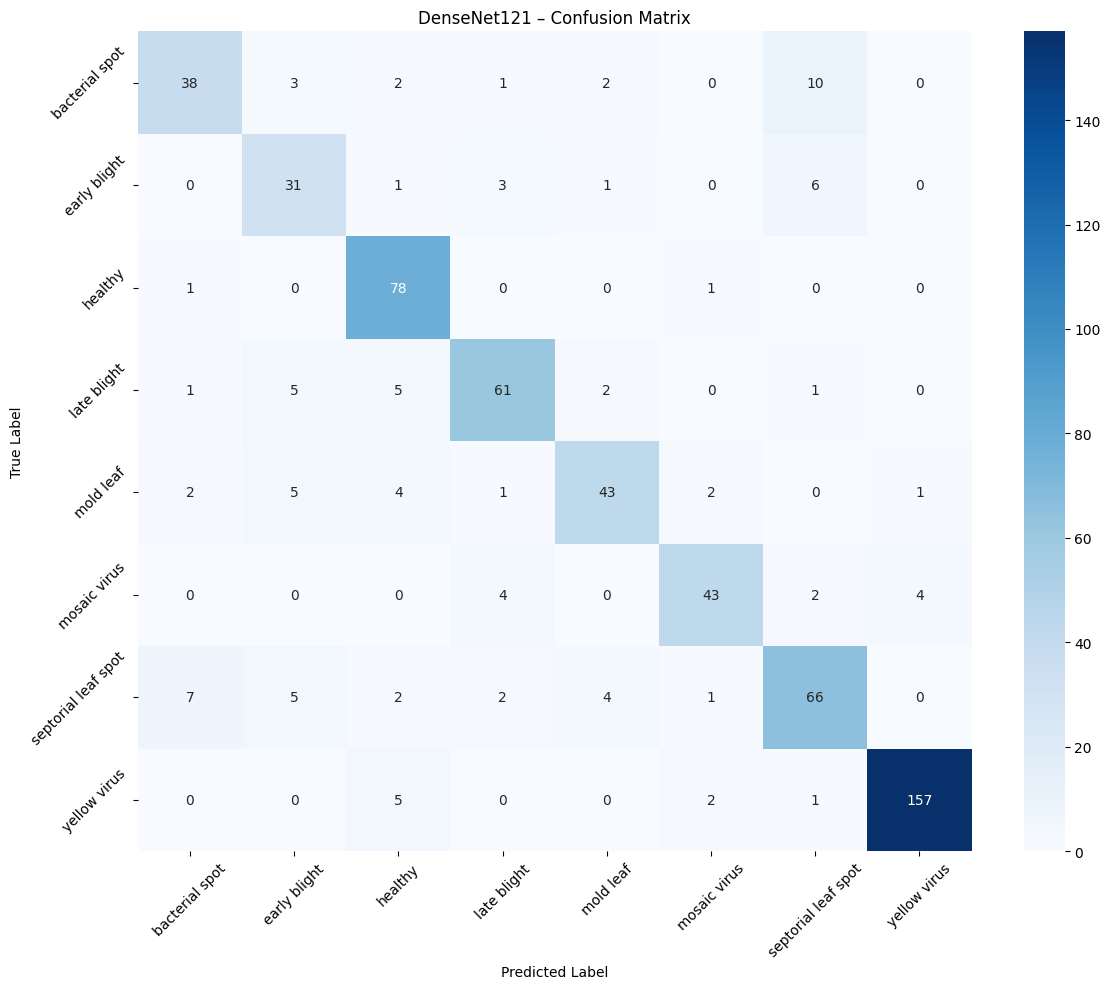

Classification Report:

                     precision    recall  f1-score   support

     bacterial spot       0.78      0.68      0.72        56
       early blight       0.63      0.74      0.68        42
            healthy       0.80      0.97      0.88        80
        late blight       0.85      0.81      0.83        75
          mold leaf       0.83      0.74      0.78        58
       mosaic virus       0.88      0.81      0.84        53
septorial leaf spot       0.77      0.76      0.76        87
       yellow virus       0.97      0.95      0.96       165

           accuracy                           0.84       616
          macro avg       0.81      0.81      0.81       616
       weighted avg       0.84      0.84      0.84       616



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("DenseNet121 – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


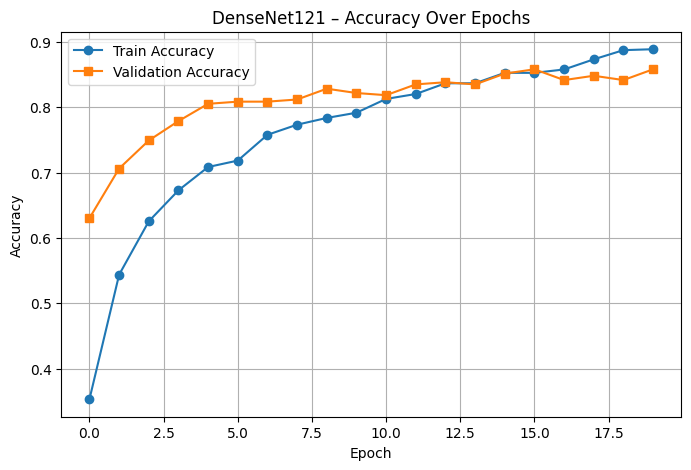

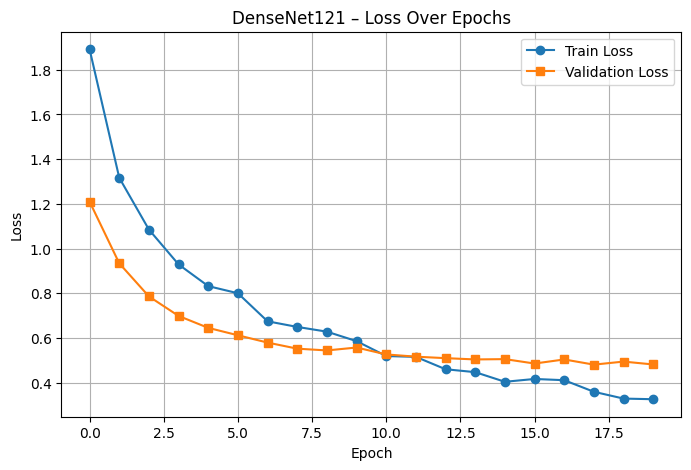

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('DenseNet121 – Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('DenseNet121 – Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/densenet121_final_model.h5')
print("✅ DenseNet121 model saved.")


✅ DenseNet121 model saved.
